**Set-up**

In [2]:
import argparse
import json
import os
import pickle
import shutil
import subprocess
import sys
from dataclasses import dataclass
from typing import Any, Dict, List, Optional
import matplotlib.pyplot as plt
import cv2
import hydra
import glob
import numpy as np
from PIL import Image
import pandas as pd
import random
from ego4d.internal.colmap.preprocess import download_andor_generate_streams
from ego4d.research.readers import PyAvReader
from ego4d.internal.human_pose.bbox_detector import DetectorModel
from ego4d.internal.human_pose.camera import (
    batch_xworld_to_yimage,
    create_camera,
    create_camera_data,
    get_aria_camera_models
)
from ego4d.internal.human_pose.config import Config
from ego4d.internal.human_pose.dataset import (
    get_synced_timesync_df,
    SyncedEgoExoCaptureDset,
)
from ego4d.internal.human_pose.pose_estimator import PoseModel
from ego4d.internal.human_pose.readers import read_frame_idx_set
from ego4d.internal.human_pose.triangulator import Triangulator
from ego4d.internal.human_pose.utils import (
    check_and_convert_bbox,
    draw_bbox_xyxy,
    draw_points_2d,
    get_exo_camera_plane,
    get_region_proposal,
    get_bbox_fromKpts,
    get_two_small_bboxes,
    left_right_bboxes_div,
    aria_extracted_to_original,
    aria_original_to_extracted
)

from iopath.common.file_io import PathManager
from iopath.common.s3 import S3PathHandler
from tqdm.auto import tqdm

from mmdet.apis import inference_detector, init_detector

pathmgr = PathManager()
pathmgr.register_handler(S3PathHandler(profile="default"))
%matplotlib inline

import projectaria_tools

/home/jinxu/miniconda3/envs/human_pose/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/jinxu/code/Ego4d/ego4d/internal/colmap/preprocess.py:648: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  @hydra.main(config_path="configs", config_name=None)


apex is not installed
apex is not installed
apex is not installed


#### Demo: Video to image in `preprocess`

In [ ]:
path = '/media/jinxu/New Volume/ego4dData/takes/sfu_cooking_013_3/frame_aligned_videos/cam01.mp4'
reader = PyAvReader(
                path=path,
                resize=None,
                mean=None,
                frame_window_size=1,
                stride=1,
                gpu_idx=-1,
            )

print(len(reader))

#### Extract Aria calibration

In [ ]:
all_take_root = "/media/jinxu/New Volume/ego4dData/takes"
all_capture_root = "/media/jinxu/New Volume/ego4dData/captures"
all_takes = os.listdir(all_take_root)
print('All downloaded takes:')
for t in all_takes:
    print(t)

In [ ]:
import projectaria_tools

#########################
test_take = 'iiith_cooking_01_1'
#########################

# ----------------- code from camera.py ----------------- #
test_capture = "_".join(test_take.split('_')[:-1])
aria_path = os.path.join(all_capture_root, test_capture, "videos/aria01.vrs")

vrs_data_provider = projectaria_tools.dataprovider.AriaVrsDataProvider()
vrs_data_provider.openFile(aria_path)

aria_stream_id = projectaria_tools.dataprovider.StreamId(214, 1)
vrs_data_provider.setStreamPlayer(aria_stream_id)
vrs_data_provider.readFirstConfigurationRecord(aria_stream_id)

aria_stream_id = projectaria_tools.dataprovider.StreamId(1201, 1)
vrs_data_provider.setStreamPlayer(aria_stream_id)
vrs_data_provider.readFirstConfigurationRecord(aria_stream_id)

aria_stream_id = projectaria_tools.dataprovider.StreamId(1201, 2)
vrs_data_provider.setStreamPlayer(aria_stream_id)
vrs_data_provider.readFirstConfigurationRecord(aria_stream_id)

assert vrs_data_provider.loadDeviceModel()

aria_camera_model = vrs_data_provider.getDeviceModel()
slam_left = aria_camera_model.getCameraCalib("camera-slam-left")
slam_right = aria_camera_model.getCameraCalib("camera-slam-right")
rgb_cam = aria_camera_model.getCameraCalib("camera-rgb")
# -------------------------------------------------------- #

In [ ]:
rgb_cam.T_Device_Camera

#### Using Calibration Sensor Data [(legacy)](https://facebookresearch.github.io/Aria_data_tools/docs/howto/calibration/#intrinsics)

Reproject wholebody-Hand pose3d kpts onto aria image plane

In [7]:
########### Parameter ###########
test_case = 'georgiatech_covid_02_2' # iu_music, georgiatech_covid_02_2, iiith_cooking_01_1, sfu_cooking_013_3
# exo_cam_names = ['cam02','cam03']
tri_threshold = 0.5
legacy = test_case in ['iu_music']
#################################
if legacy:
    dataset_dir = f'/media/jinxu/New Volume/ego4dData/cache/{test_case}/dataset'
    dset = SyncedEgoExoCaptureDset(
        data_dir="/media/jinxu/New Volume/ego4dData",
        dataset_json_path=f"/media/jinxu/New Volume/ego4dData/cache/{test_case}/dataset/data.json",
        read_frames=False,
        legacy=legacy
    )
    aria_path = f"/media/jinxu/New Volume/ego4dData/cache/{test_case}/aria01.vrs"
    # Name mapping from dset to get_aria_camera_model
    stream_name_to_id = {
        "aria_rgb": "214-1",
        "aria_slam_left": "1201-1",
        "aria_slam_right": "1201-2",
    }
else:
    dataset_dir = f'/media/jinxu/New Volume/ego4dData/cache/{test_case}'
    dset = SyncedEgoExoCaptureDset(
        data_dir="/media/jinxu/New Volume/ego4dData",
        dataset_json_path=f"/media/jinxu/New Volume/ego4dData/cache/{test_case}/data.json",
        read_frames=False,
        legacy=legacy
    )
    test_capture = "_".join(test_case.split('_')[:-1])
    aria_path = f"/media/jinxu/New Volume/ego4dData/captures/{test_capture}/videos/aria01.vrs"
    # Name mapping from dset to get_aria_camera_model
    stream_name_to_id = {
        "aria01_rgb": "214-1",
        "aria01_slam-left": "1201-1",
        "aria01_slam-right": "1201-2",
    }

# Hand pose2d model
hand_pose_config = 'external/mmlab/mmpose/configs/hand/2d_kpt_sview_rgb_img/topdown_heatmap/coco_wholebody_hand/hrnetv2_w18_coco_wholebody_hand_256x256_dark.py'
hand_pose_ckpt = 'https://download.openmmlab.com/mmpose/hand/dark/hrnetv2_w18_coco_wholebody_hand_256x256_dark-a9228c9c_20210908.pth'
hand_pose_model = PoseModel(
    hand_pose_config, 
    hand_pose_ckpt, 
    rgb_keypoint_thres=0.3, 
    rgb_keypoint_vis_thres=0.3,
    refine_bbox=False)

# Load 3d wholebody-hand kpts
pose3d_dir = os.path.join(dataset_dir, 'body/pose3d', f'wholebodyHand_pose3d_triThresh={tri_threshold}.pkl')
with open(pose3d_dir, "rb") as f:
    wholebodyHand_pose3d = pickle.load(f)


def get_aria_camera_models(aria_path):
    try:
        from projectaria_tools.core import data_provider

        vrs_data_provider = data_provider.create_vrs_data_provider(aria_path)
        aria_camera_model = vrs_data_provider.get_device_calibration()
        slam_left = aria_camera_model.get_camera_calib("camera-slam-left")
        slam_right = aria_camera_model.get_camera_calib("camera-slam-right")
        rgb_cam = aria_camera_model.get_camera_calib("camera-rgb")
    except Exception as e:
        print(
            f"[Warning] Hitting exception {e}. Fall back to old projectaria_tools ..."
        )
        import projectaria_tools

        vrs_data_provider = projectaria_tools.dataprovider.AriaVrsDataProvider()
        vrs_data_provider.openFile(aria_path)

        aria_stream_id = projectaria_tools.dataprovider.StreamId(214, 1)
        vrs_data_provider.setStreamPlayer(aria_stream_id)
        vrs_data_provider.readFirstConfigurationRecord(aria_stream_id)

        aria_stream_id = projectaria_tools.dataprovider.StreamId(1201, 1)
        vrs_data_provider.setStreamPlayer(aria_stream_id)
        vrs_data_provider.readFirstConfigurationRecord(aria_stream_id)

        aria_stream_id = projectaria_tools.dataprovider.StreamId(1201, 2)
        vrs_data_provider.setStreamPlayer(aria_stream_id)
        vrs_data_provider.readFirstConfigurationRecord(aria_stream_id)

        assert vrs_data_provider.loadDeviceModel()

        aria_camera_model = vrs_data_provider.getDeviceModel()
        slam_left = aria_camera_model.getCameraCalib("camera-slam-left")
        slam_right = aria_camera_model.getCameraCalib("camera-slam-right")
        rgb_cam = aria_camera_model.getCameraCalib("camera-rgb")

    assert slam_left is not None
    assert slam_right is not None
    assert rgb_cam is not None

    return {
        "1201-1": slam_left,
        "1201-2": slam_right,
        "214-1": rgb_cam,
    }


# Aria camera models 
cam_model_dict = get_aria_camera_models(aria_path)

# List all ego camera names
print('All valid camera names:\n', dset[0].keys())

load checkpoint from http path: https://download.openmmlab.com/mmpose/hand/dark/hrnetv2_w18_coco_wholebody_hand_256x256_dark-a9228c9c_20210908.pth
[Warning] Hitting exception No module named 'projectaria_tools.core'; 'projectaria_tools' is not a package. Fall back to old projectaria_tools ...
All valid camera names:
 dict_keys(['aria01_rgb', 'aria01_slam-left', 'aria01_slam-right', 'cam01_0', 'cam02_0', 'cam03_0', 'cam04_0'])


[VRSIndexRecord][WARNING]: 6 record(s) not sorted properly. Sorting index.


Eye stream player doesn't exist, cannot update camera calibration


In [8]:
for k in cam_model_dict.keys():
    print('='*15,'T_camera_device for',k,'='*15)
    R = cam_model_dict[k].T_Device_Camera.rotationMatrix()
    t = cam_model_dict[k].T_Device_Camera.translation()
    T_device_camera = np.zeros((4, 4))
    T_device_camera[0:3, 0:3] = R
    T_device_camera[0:3, 3] = t
    T_device_camera[3, 3] = 1.0
    T_camera_device = np.linalg.inv(T_device_camera)

    print(T_camera_device)

=============== T_camera_device for 1201-1 ===============
[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00 -3.46944695e-18]
 [ 0.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
=============== T_camera_device for 1201-2 ===============
[[ 0.99878392  0.04705557  0.01471248  0.00148557]
 [-0.02577281  0.24393412  0.96944928  0.11237589]
 [ 0.04202911 -0.96864953  0.24485023 -0.08690043]
 [ 0.          0.          0.          1.        ]]
=============== T_camera_device for 214-1 ===============
[[ 0.9942372   0.09624948 -0.04720625  0.00518318]
 [-0.04628117  0.78257024  0.62083965  0.01250964]
 [ 0.0966977  -0.61507712  0.78251498 -0.00310918]
 [ 0.          0.          0.          1.        ]]


[[-0.50458373  0.4351494  -0.74568107 -2.0196391 ]
 [ 0.01062484  0.86675813  0.49861554  0.05180901]
 [ 0.86329739  0.24367055 -0.44197544  3.2879348 ]
 [ 0.          0.          0.          1.        ]]


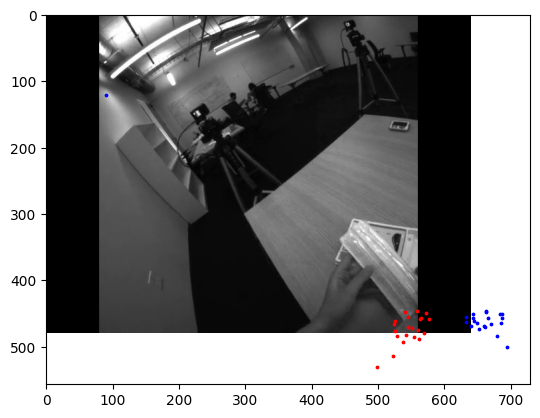

In [13]:
###########################
timestamp = 45
test_cam_name = 'aria01_slam-left' # Please adjust based on the print out from last cell
###########################

# Load in aria image
image_path = dset[timestamp][test_cam_name]['abs_frame_path']
image = cv2.imread(image_path)
img_H, img_W = image.shape[:2]
orig_H, orig_W = img_W, img_H

# Extrinsics - from world to camera
curr_camera_data = dset[timestamp][test_cam_name]['camera_data']
curr_extrinsic = np.array(curr_camera_data["T_camera_device"]) @ np.array(curr_camera_data["T_device_world"])
print(curr_extrinsic)

# Reproject from world to camera
pose3d = wholebodyHand_pose3d[timestamp] # (N,4)
pts3d = pose3d[:,:3]
pts_cam = np.transpose(curr_extrinsic @ np.append(pts3d, np.ones((len(pts3d),1)), axis=1).T) # (N,4)

# Camera to image plane with intrinsic
pts_uv = []
curr_cam_model = cam_model_dict[stream_name_to_id[test_cam_name]]
for curr_cam_pt in pts_cam[:,:3]:
    pts_uv.append(curr_cam_model.projectionModel.project(curr_cam_pt))
pts_uv = np.array(pts_uv)

# Clip kpts coordinate range
# if legacy:
#     pts_uv[:,0] = np.clip(pts_uv[:,0],0,img_W-1)
#     pts_uv[:,1] = np.clip(pts_uv[:,1],0,img_H-1)
# else:
#     pts_uv[:,0] = np.clip(pts_uv[:,0],0,orig_W-1)
#     pts_uv[:,1] = np.clip(pts_uv[:,1],0,orig_H-1)

# Select points with nonzero conf
right_hand_kpts, left_hand_kpts = pts_uv[21:], pts_uv[:21]
right_hand_kpts, left_hand_kpts = right_hand_kpts[pose3d[21:,2]!=0,:], \
                                  left_hand_kpts[pose3d[:21,2]!=0,:]

if not legacy:
    right_hand_kpts = aria_original_to_extracted(right_hand_kpts, (orig_H, orig_W))
    left_hand_kpts = aria_original_to_extracted(left_hand_kpts, (orig_H, orig_W))

# Visualization
plt.figure()
plt.imshow(image[:,:,::-1])
plt.scatter(right_hand_kpts[:,0], right_hand_kpts[:,1], s=3, color='b') # [x, y]
plt.scatter(left_hand_kpts[:,0], left_hand_kpts[:,1], s=3, color='r')

# save_path = 'transfer_test/aria_reprojected_wholebodyHand_pose3Dkpts_legacy.jpg'
# projected_pose3d = np.concatenate(
#         [pts_uv, pose3d[:, 3].reshape(-1, 1)], axis=1
#     )
# hand_pose_model.draw_projected_poses3d([projected_pose3d[:21], projected_pose3d[21:]], image, save_path)
# plt.figure()
# plt.imshow(cv2.imread(save_path)[:,:,::-1])

**Incorporate Aria calibration model into `Camera`**

In [17]:
import copy
from dataclasses import dataclass
from typing import Any, Dict, Optional, Union
import pycolmap

##############################
test_case = "georgiatech_covid_02_2"
test_capture = "_".join(test_case.split('_')[:-1])
##############################

# Load dataset
data_dir = "/media/jinxu/New Volume/ego4dData"
dset = SyncedEgoExoCaptureDset(
        data_dir=data_dir,
        dataset_json_path=f"/media/jinxu/New Volume/ego4dData/cache/{test_case}/data.json",
        read_frames=False,
    )

# Load aria camera model
aria_path = f"/media/jinxu/New Volume/ego4dData/captures/{test_capture}/videos/aria01.vrs"      # os.path.join(capture_dir, "videos/aria01.vrs")
assert os.path.exists(aria_path), f"{aria_path} doesn\'t exit. Need aria video downloaded"
aria_camera_models = get_aria_camera_models(aria_path)
stream_name_to_id = {
        "aria01_rgb": "214-1",
        "aria01_slam-left": "1201-1",
        "aria01_slam-right": "1201-2",
    }

Vec2 = np.array
Vec3 = np.array
Mat44 = np.array
AriaCameraModel = Any

@dataclass
class Camera:
    name: str
    camera_type: str
    center: Vec3  # in world coords
    T_device_world: Mat44  # project world pt into device frame
    T_world_device: Mat44  # project device pt into world frame
    T_device_camera: Mat44  # project camera pt into device frame
    T_camera_device: Mat44  # project device pt into camera frame
    camera_model: Union[pycolmap.Camera, AriaCameraModel]  # intrinsics
    device_row: dict  # raw data constructed camera from
    extrinsics: Mat44  # project world pt into camera frame


class legacy_aria_cameraModel:
    def __init__(self, camera_name, camera_model):
        self.camera_name = camera_name
        self.camera_model = camera_model

    def image_to_world(self, point_2d):
        return self.camera_model.projectionModel.unproject(point_2d)
    
    def world_to_image(self, pt):
        pt_padded = np.append(pt, 1)
        return self.camera_model.projectionModel.project(pt_padded)

########### Mofidied by jinxu ###############
def create_camera(camera_data, camera_model):
    ret = copy.deepcopy(camera_data)
    if camera_data["camera_type"] == "aria":
        ret["camera_model"] = camera_model
    else:
        ret["camera_model"] = _create_exo_camera(ret["device_row"])

    for key in [
        "center",
        "T_device_world",
        "T_world_device",
        "T_device_camera",
        "T_camera_device",
    ]:
        ret[key] = np.array(camera_data[key])

    ret["extrinsics"] = (
        ret["T_camera_device"] @ ret["T_device_world"]
    )  ## map world point to camera frame
    return Camera(**ret)


def _create_exo_camera(exo_cam_desc):
    params = [exo_cam_desc[f"intrinsics_{i}"] for i in range(8)]
    camera = pycolmap.Camera(
        model="OPENCV_FISHEYE",
        width=exo_cam_desc["image_width"],
        height=exo_cam_desc["image_height"],
        params=params,
    )
    return camera

[Warning] Hitting exception No module named 'projectaria_tools.core'; 'projectaria_tools' is not a package. Fall back to old projectaria_tools ...
Eye stream player doesn't exist, cannot update camera calibration


[VRSIndexRecord][WARNING]: 6 record(s) not sorted properly. Sorting index.


In [18]:
###########################
timestamp = 1
camera_name = 'aria01_rgb'
###########################

# Load in aria image
image_path = dset[timestamp][camera_name]["abs_frame_path"]
image = cv2.imread(image_path)

# Create camera 
curr_camera_data = dset[timestamp][camera_name]['camera_data']
ari_calib_model = legacy_aria_cameraModel(camera_name, aria_camera_models[stream_name_to_id[camera_name]])
aria_camera = create_camera(curr_camera_data, ari_calib_model)

#### Multiview stitched pose estimation visualization

**Exo & Ego camera pose2d visualization**

In [29]:
########### Parameter ###########
scenario = 'georgiatech_covid_02_2'
vis_cam_name = ['cam01', 'cam02', 'cam03', 'cam04', 'aria01_rgb'] # sorted(os.listdir(vis_pose_root)) Make sure exo camera is first
kpts_vis_threshold = 0.1
#################################

# Image directories
vis_pose_root = f"/media/jinxu/New Volume/ego4dData/cache/{scenario}/hand/vis_pose2d/visThresh={kpts_vis_threshold}"
dataset_dir = {curr_cam : sorted(glob.glob(os.path.join(vis_pose_root, f"{curr_cam}_rtmpose", '*'))) for curr_cam in vis_cam_name}
num_img = len(dataset_dir[vis_cam_name[0]])
# Visualization save directory
save_dir = os.path.join(vis_pose_root, 'Multiview')
os.makedirs(save_dir, exist_ok=True)

In [30]:
num_rows = 3
num_cols = 2
vis_H, vis_W = 1080, 1920
total_height, total_width = num_rows * vis_H, num_cols * vis_W
# Iterate through all images
for idx in tqdm(range(num_img)):
    canvas = 255 * np.zeros((total_height, total_width, 3))
    for img_idx, curr_cam_name in enumerate(vis_cam_name):
        if 'aria' not in curr_cam_name:
            curr_img_dir = dataset_dir[curr_cam_name][idx]
            camera_image = cv2.resize(cv2.imread(curr_img_dir), (vis_W, vis_H))

            # Append current image into canvas
            row_idx = img_idx // num_cols
            col_idx = img_idx % num_cols

            origin_x = vis_W * col_idx
            origin_y = vis_H * row_idx
            canvas[origin_y:origin_y+vis_H, origin_x:origin_x+vis_W, :] = camera_image
        else:
            aria_origin_y, aria_origin_x = (num_rows-1)*vis_H, (vis_W-vis_H)//2
            curr_img_dir = dataset_dir[curr_cam_name][idx]
            vis_aria_img = cv2.resize(cv2.imread(curr_img_dir), (vis_H, vis_H))
            canvas[aria_origin_y:aria_origin_y+vis_H, aria_origin_x:aria_origin_x+vis_H] = vis_aria_img

    # Save result
    # canvas = cv2.resize(canvas, (5760,2160))
    cv2.imwrite(os.path.join(save_dir, f'{idx:06d}.jpg'), canvas)

100%|██████████| 450/450 [06:55<00:00,  1.08it/s]


**Exo & Ego camera pose3d visualization**

In [8]:
# All datasets
dataset_root = "/media/jinxu/New Volume/ego4dData" # '/mnt/shared/ego4dData'
dataset_dir = os.path.join(dataset_root, 'cache')
print('All datasets:\n', os.listdir(dataset_dir))

All datasets:
 ['georgiatech_covid_02_2', 'iiith_cooking_01_1', 'iu_music', 'iu_music_Latest', 'sfu_cooking_013_3']


In [9]:
########### Parameter ###########
scenario = 'georgiatech_covid_02_2'
vis_cam_name = ['cam01', 'cam02', 'cam03', 'cam04', 'aria01_rgb'] # sorted(os.listdir(vis_pose_root)) Make sure exo camera is first
tri_threshold = 0.2
camera_used = 'ego_exo_camera'
assert camera_used in ['ego_exo_camera', 'exo_camera'], f"cameras_used has to be one of ['ego_exo_camera', 'exo_camera']"
#################################

# Image directories
vis_pose_root = f"/media/jinxu/New Volume/ego4dData/cache/{scenario}/hand/vis_pose3d/{camera_used}/triThresh={tri_threshold}"
dataset_dir = {curr_cam : sorted(glob.glob(os.path.join(vis_pose_root, curr_cam, '*'))) for curr_cam in vis_cam_name}
num_img = len(dataset_dir[vis_cam_name[0]])
# Visualization save directory
save_dir = os.path.join(vis_pose_root, 'Multiview')
os.makedirs(save_dir, exist_ok=True)

In [10]:
num_rows = 3
num_cols = 2
vis_H, vis_W = 1080, 1920
total_height, total_width = num_rows * vis_H, num_cols * vis_W
# Iterate through all images
for idx in tqdm(range(num_img)):
    canvas = 255 * np.zeros((total_height, total_width, 3))
    for img_idx, curr_cam_name in enumerate(vis_cam_name):
        if 'aria' not in curr_cam_name:
            curr_img_dir = dataset_dir[curr_cam_name][idx]
            camera_image = cv2.resize(cv2.imread(curr_img_dir), (vis_W, vis_H))

            # Append current image into canvas
            row_idx = img_idx // num_cols
            col_idx = img_idx % num_cols

            origin_x = vis_W * col_idx
            origin_y = vis_H * row_idx
            canvas[origin_y:origin_y+vis_H, origin_x:origin_x+vis_W, :] = camera_image
        else:
            aria_origin_y, aria_origin_x = (num_rows-1)*vis_H, (vis_W-vis_H)//2
            curr_img_dir = dataset_dir[curr_cam_name][idx]
            vis_aria_img = cv2.resize(cv2.imread(curr_img_dir), (vis_H, vis_H))
            canvas[aria_origin_y:aria_origin_y+vis_H, aria_origin_x:aria_origin_x+vis_H] = vis_aria_img

    # Save result
    # canvas = cv2.resize(canvas, (5760,2160))
    cv2.imwrite(os.path.join(save_dir, f'{idx:06d}.jpg'), canvas)

100%|██████████| 450/450 [07:33<00:00,  1.01s/it]
